In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



Using TensorFlow backend.


# Tasks 

### Generate a model in any DL/ML frameworks and use this data to learn to classify a 60 element DNA sequence into the categories of IE, EI or neither.
### Compare performance of classical machine learning models and deep learning models.
__Focus on making a thoughtful analysis on the comparison than raising the absolute perfomances of the methods.__



# Dataset

This is a dataset of DNA sequences that define the boundaries between regions that are spliced out during protein creation (introns) or retained for protein creation (exons).

There are 3 classes: boundaries between exon and intron sequences (EI), boundaries between intron and exon sequences (IE), or sequences that are neither.

The dataset has 3190 examples of DNA sequences.
Each sequence is 60 base-pairs long.




# Approaches

### 1. Classical machine learning algorithms
### 2. Deep learning algorithms using Keras neural network


# Feature selection and preprocessing

In [2]:
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['A','C','G','T','Z']))
#Z for variables that are not A C G T , 
#Variables other than 4 characters are regarded equally.

def one_hot_encoder(array):
    integer_encoded = label_encoder.transform(array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int, categories=[range(5)])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column )], axis=1 )
        data = data.drop(column, axis=1 )
    return data


    

In [3]:
#label encoder to float numbers
def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, z
    return float_encoded

#change the string sequence to array
def string_to_array(my_string):
    my_string = re.sub('[^ACGT]', 'Z', my_string)
    my_array = np.array(list(my_string))
    return my_array


In [4]:
# read data with pandas
data = pd.read_csv("splice.data",names = ["label", "attributes", "sequence"])
data2 = data.copy()

In [5]:
data.shape

(3190, 3)

In [6]:
data.head()

,label,attributes,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


---

### The attributes column was not reliable for the analysis.

The column consisted of data that was stricted related to the label. 
(e.g. the DONOR -> EI , NEG -> N ) 

__Therefore, in this task the column should be deleted__ 

---

In [7]:
data.sequence = data.sequence.str.lstrip()
#erase the empty space in front of sequence column

def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

data['words'] = data.apply(lambda x: getKmers(x['sequence']), axis=1)
data = data.drop('sequence', axis=1)


In [8]:
dna_texts = list(data['words'])

In [9]:
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])
y_dna = data.iloc[:, 0].values

In [10]:
dna_texts[0]

'ccagct cagctg agctgc gctgca ctgcat tgcatc gcatca catcac atcaca tcacag cacagg acagga caggag aggagg ggaggc gaggcc aggcca ggccag gccagc ccagcg cagcga agcgag gcgagc cgagca gagcag agcagg gcaggt caggtc aggtct ggtctg gtctgt tctgtt ctgttc tgttcc gttcca ttccaa tccaag ccaagg caaggg aagggc agggcc gggcct ggcctt gccttc ccttcg cttcga ttcgag tcgagc cgagcc gagcca agccag gccagt ccagtc cagtct agtctg'

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(dna_texts)
#use count vectorizer to vectorize and count sequences of equal length 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_dna, 
                                                    test_size = 0.20)

# print(y_train)

In [15]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


Confusion matrix

Predicted  EI  IE    N
Actual                
EI         97   6   33
IE          5  99   49
N          76  65  208
accuracy = 0.633 
precision = 0.648 
recall = 0.633 
f1 = 0.635


### Above codes only demonstrates that using kmer algorithm to group dna sequences into groups were not very successful in achieving classification 
---
### Therefore, the onehot encoding and label encoding were used in feature selection process

---

In [16]:
#erase empty space on the left
data2.sequence = data2.sequence.str.lstrip()

#change string sequence into array
data2["sequence"]= data2["sequence"].apply(string_to_array)

data2.head()

,label,attributes,sequence
0,EI,ATRINS-DONOR-521,"[C, C, A, G, C, T, G, C, A, T, C, A, C, A, G, ..."
1,EI,ATRINS-DONOR-905,"[A, G, A, C, C, C, G, C, C, G, G, G, A, G, G, ..."
2,EI,BABAPOE-DONOR-30,"[G, A, G, G, T, G, A, A, G, G, A, C, G, T, C, ..."
3,EI,BABAPOE-DONOR-867,"[G, G, G, C, T, G, C, G, T, T, G, C, T, G, G, ..."
4,EI,BABAPOE-DONOR-2817,"[G, C, T, C, A, G, C, C, C, C, C, A, G, G, T, ..."


In [17]:
#for each array index create a column
OHEdata= data2.sequence.apply(pd.Series, index=list(range(0,60)))

data2["sequence"]= data2["sequence"].apply(ordinal_encoder) 
#comment out for the case of label encoding

labeldata= data2.sequence.apply(pd.Series, index=list(range(0,60)))

labeldata.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.50,0.50,0.25,0.75,0.50,1.00,0.75,0.50,0.25,1.00,...,0.25,0.75,0.50,0.50,0.25,0.75,1.00,0.50,1.00,0.75
1,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,0.50,0.75,...,0.75,1.00,0.75,0.50,0.50,0.50,0.50,0.50,0.75,0.50
2,0.75,0.25,0.75,0.75,1.00,0.75,0.25,0.25,0.75,0.75,...,0.50,0.25,0.50,0.75,0.75,0.75,0.75,0.25,1.00,0.75
3,0.75,0.75,0.75,0.50,1.00,0.75,0.50,0.75,1.00,1.00,...,0.75,0.75,1.00,1.00,1.00,1.00,0.50,0.50,0.50,0.50
4,0.75,0.50,1.00,0.50,0.25,0.75,0.50,0.50,0.50,0.50,...,0.50,0.50,1.00,1.00,0.75,0.25,0.50,0.50,0.50,1.00


# **Label encoded data were tested

*__OneHot encoded dummy data performed better in classification tasks both for ML and DL__*

---

In [18]:

col = [OHEdata.columns]
dummy= dummy_data(OHEdata, col)
#make a dummy onehot encoded dataset

dummy["label"]=data["label"]



In [19]:
dummy.head()

,0_A,0_C,0_G,0_T,0_Z,1_A,1_C,1_G,1_T,1_Z,...,58_C,58_G,58_T,58_Z,59_A,59_C,59_G,59_T,59_Z,label
0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,EI
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,EI
2,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,EI
3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,EI
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,EI


In [20]:
labeldata["label"]=data2["label"]
labeldata.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,label
0,0.50,0.50,0.25,0.75,0.50,1.00,0.75,0.50,0.25,1.00,...,0.75,0.50,0.50,0.25,0.75,1.00,0.50,1.00,0.75,EI
1,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,0.50,0.75,...,1.00,0.75,0.50,0.50,0.50,0.50,0.50,0.75,0.50,EI
2,0.75,0.25,0.75,0.75,1.00,0.75,0.25,0.25,0.75,0.75,...,0.25,0.50,0.75,0.75,0.75,0.75,0.25,1.00,0.75,EI
3,0.75,0.75,0.75,0.50,1.00,0.75,0.50,0.75,1.00,1.00,...,0.75,1.00,1.00,1.00,1.00,0.50,0.50,0.50,0.50,EI
4,0.75,0.50,1.00,0.50,0.25,0.75,0.50,0.50,0.50,0.50,...,0.50,1.00,1.00,0.75,0.25,0.50,0.50,0.50,1.00,EI


In [21]:
dummy.shape

(3190, 286)

In [22]:

X = dummy.drop(['label'], axis = 1)
y = dummy['label']

# X = labeldata.drop(['label'], axis = 1)
# y = labeldata['label']

print(X.shape)
print(y.shape)

(3190, 285)
(3190,)


In [23]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print(X_train[0:5])

      0_A  0_C  0_G  0_T  0_Z  1_A  1_C  1_G  1_T  1_Z  ...   58_A  58_C  \
533     0    0    1    0    0    0    0    1    0    0  ...      0     1   
1937    0    0    1    0    0    0    1    0    0    0  ...      0     1   
2609    1    0    0    0    0    0    0    0    1    0  ...      0     0   
2307    1    0    0    0    0    0    0    1    0    0  ...      0     1   
2509    0    1    0    0    0    0    0    1    0    0  ...      0     0   

      58_G  58_T  58_Z  59_A  59_C  59_G  59_T  59_Z  
533      0     0     0     0     0     0     1     0  
1937     0     0     0     0     1     0     0     0  
2609     0     1     0     0     0     0     1     0  
2307     0     0     0     1     0     0     0     0  
2509     0     1     0     0     0     0     1     0  

[5 rows x 285 columns]


In [24]:
from keras.callbacks import EarlyStopping

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(120,input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(150, activation='relu'))
    #model.add(Dropout(0.2))
    #odel.add(Dense(10, activation='relu'))
    #odel.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

monitor = EarlyStopping(monitor ='val_loss' , mode ='auto', patience=20, verbose=1 )
callbacks=[monitor]
#to avoid overfitting, set an early stopping criteria for the model


estimator = KerasClassifier(build_fn=create_model, epochs = 200, batch_size= 20, verbose=1, callbacks=callbacks, validation_split=0.20)

estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)



Train on 2041 samples, validate on 511 samples
Epoch 1/200
2041/2041 [==============================] - 0s 153us/step - loss: 0.7520 - acc: 0.6703 - val_loss: 0.3532 - val_acc: 0.9041
Epoch 2/200
2041/2041 [==============================] - 0s 53us/step - loss: 0.3052 - acc: 0.8956 - val_loss: 0.1966 - val_acc: 0.9491
Epoch 3/200
2041/2041 [==============================] - 0s 48us/step - loss: 0.1906 - acc: 0.9358 - val_loss: 0.1654 - val_acc: 0.9491
Epoch 4/200
2041/2041 [==============================] - 0s 46us/step - loss: 0.1445 - acc: 0.9559 - val_loss: 0.1572 - val_acc: 0.9413
Epoch 5/200
2041/2041 [==============================] - 0s 45us/step - loss: 0.1331 - acc: 0.9579 - val_loss: 0.1502 - val_acc: 0.9452
Epoch 6/200
2041/2041 [==============================] - 0s 45us/step - loss: 0.1112 - acc: 0.9672 - val_loss: 0.1566 - val_acc: 0.9452
Epoch 7/200
2041/2041 [==============================] - 0s 50us/step - loss: 0.0814 - acc: 0.9731 - val_loss: 0.1540 - val_acc: 0.9491


---

### Number of hidden layer node and number of Hidden layers were not closely related to the output of the results of classification 

## 1. To avoid overfitting there the validation loss was chosen as a threshold for epochs
## 2. dropout was also set to avoid overfitting


---

In [25]:
def ploting(cm, classes,
                    normalize=False,
                    title='Confusion matrix',
                    cmap=plt.cm.Blues):
    """
    This inner function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param: cm/ConfusionMatrixo object, normalize=true/false, title=(str) , cmap= plt.cm.Blues ( color )
    :return: None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion(y_pred):

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    ploting(cnf_matrix, classes=dummy["label"].unique(),
                            title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    ploting(cnf_matrix, classes=dummy["label"].unique(), normalize=True,
                            title='Normalized confusion matrix')

    plt.show()

FeedForward Neural network Accuracy:  0.9498432601880877
              precision    recall  f1-score   support

          EI       0.92      0.96      0.94       179
          IE       0.93      0.92      0.92       140
           N       0.97      0.96      0.97       319

   micro avg       0.95      0.95      0.95       638
   macro avg       0.94      0.95      0.94       638
weighted avg       0.95      0.95      0.95       638

Confusion matrix, without normalization
[[172   4   3]
 [  6 129   5]
 [  8   6 305]]
Normalized confusion matrix
[[0.96 0.02 0.02]
 [0.04 0.92 0.04]
 [0.03 0.02 0.96]]


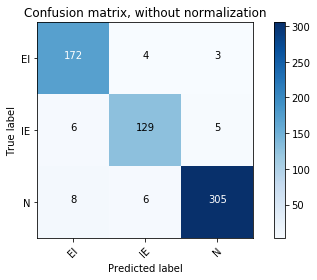

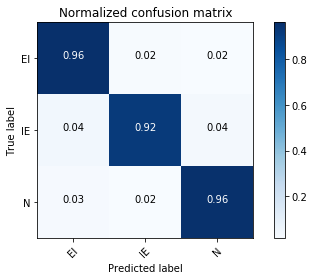

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print("FeedForward Neural network Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

### Confusion matrix visualizes the classication errors and accuracy

---

In [27]:
# kfold = KFold(n_splits=10, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# accuracy = accuracy_score(y_test, results)
# print("Crossvalidation Accuracy: " , accuracy)


k_neighbor Accuracy:  0.9278996865203761
              precision    recall  f1-score   support

          EI       0.94      0.88      0.91       179
          IE       0.88      0.93      0.90       140
           N       0.94      0.95      0.95       319

   micro avg       0.93      0.93      0.93       638
   macro avg       0.92      0.92      0.92       638
weighted avg       0.93      0.93      0.93       638

Confusion matrix, without normalization
[[158   9  12]
 [  4 130   6]
 [  6   9 304]]
Normalized confusion matrix
[[0.88 0.05 0.07]
 [0.03 0.93 0.04]
 [0.02 0.03 0.95]]


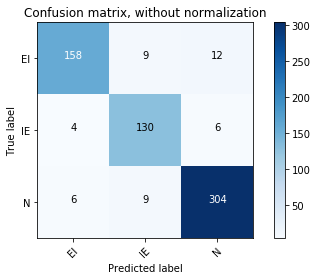

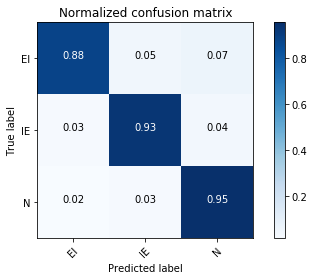

In [28]:

knn = KNeighborsClassifier(n_neighbors=500, leaf_size=3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("k_neighbor Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

Gaussian Naive Bayes Accuracy:  0.9561128526645768
              precision    recall  f1-score   support

          EI       0.95      0.96      0.96       179
          IE       0.91      0.96      0.93       140
           N       0.98      0.95      0.97       319

   micro avg       0.96      0.96      0.96       638
   macro avg       0.95      0.96      0.95       638
weighted avg       0.96      0.96      0.96       638

Confusion matrix, without normalization
[[172   6   1]
 [  1 135   4]
 [  8   8 303]]
Normalized confusion matrix
[[0.96 0.03 0.01]
 [0.01 0.96 0.03]
 [0.03 0.03 0.95]]


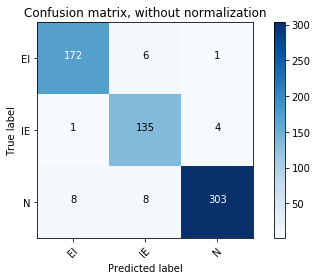

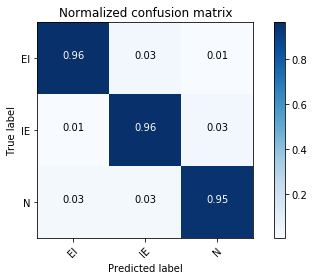

In [29]:
gnb= GaussianNB(var_smoothing = 0.1)


gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Gaussian Naive Bayes Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

D:\anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Machine Accuracy:  0.9561128526645768
              precision    recall  f1-score   support

          EI       0.96      0.97      0.96       179
          IE       0.90      0.94      0.92       140
           N       0.98      0.95      0.97       319

   micro avg       0.96      0.96      0.96       638
   macro avg       0.95      0.96      0.95       638
weighted avg       0.96      0.96      0.96       638

Confusion matrix, without normalization
[[174   5   0]
 [  3 132   5]
 [  5  10 304]]
Normalized confusion matrix
[[0.97 0.03 0.  ]
 [0.02 0.94 0.04]
 [0.02 0.03 0.95]]


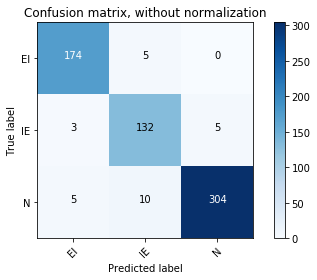

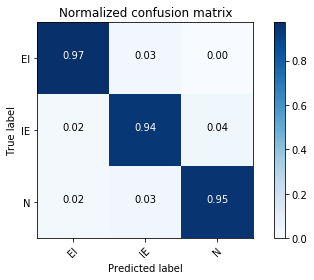

In [30]:
svc = SVC()


svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Support Vector Machine Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

RandomForestClassifier Accuracy:  0.9717868338557993
              precision    recall  f1-score   support

          EI       0.98      0.97      0.98       179
          IE       0.94      0.97      0.95       140
           N       0.98      0.97      0.98       319

   micro avg       0.97      0.97      0.97       638
   macro avg       0.97      0.97      0.97       638
weighted avg       0.97      0.97      0.97       638

Confusion matrix, without normalization
[[174   2   3]
 [  1 136   3]
 [  2   7 310]]
Normalized confusion matrix
[[0.97 0.01 0.02]
 [0.01 0.97 0.02]
 [0.01 0.02 0.97]]


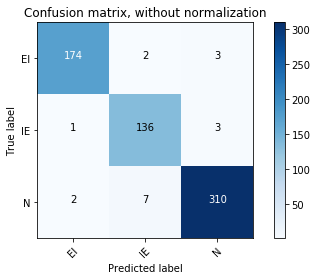

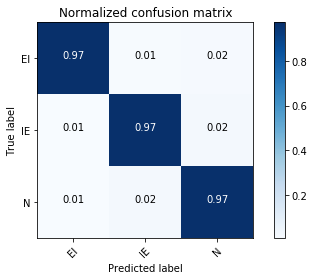

In [31]:
rnf = RandomForestClassifier(n_estimators=250, max_depth=15,
                              random_state=0)

rnf.fit(X_train, y_train)
y_pred = rnf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("RandomForestClassifier Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

DecisionTreeClassifier Accuracy:  0.9498432601880877
              precision    recall  f1-score   support

          EI       0.96      0.97      0.96       179
          IE       0.87      0.94      0.90       140
           N       0.99      0.94      0.96       319

   micro avg       0.95      0.95      0.95       638
   macro avg       0.94      0.95      0.94       638
weighted avg       0.95      0.95      0.95       638

Confusion matrix, without normalization
[[174   5   0]
 [  5 131   4]
 [  3  15 301]]
Normalized confusion matrix
[[0.97 0.03 0.  ]
 [0.04 0.94 0.03]
 [0.01 0.05 0.94]]


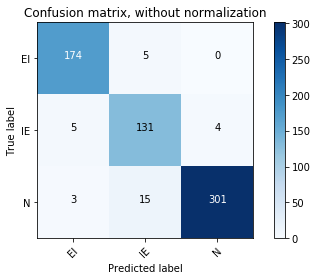

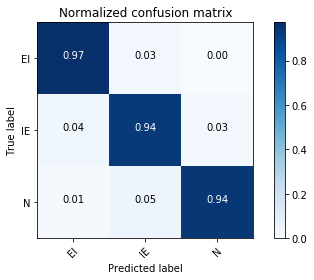

In [32]:

dct = DecisionTreeClassifier(max_depth=5, min_samples_split=3 )

dct.fit(X_train, y_train)
y_pred = dct.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("DecisionTreeClassifier Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)


[0]	validation_0-merror:0.021944	validation_0-mlogloss:1.06452	validation_1-merror:0.050157	validation_1-mlogloss:1.06628
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.019201	validation_0-mlogloss:1.03178	validation_1-merror:0.047022	validation_1-mlogloss:1.03521
[2]	validation_0-merror:0.018417	validation_0-mlogloss:1.00054	validation_1-merror:0.047022	validation_1-mlogloss:1.00562
[3]	validation_0-merror:0.017633	validation_0-mlogloss:0.97056	validation_1-merror:0.045455	validation_1-mlogloss:0.97697
[4]	validation_0-merror:0.015282	validation_0-mlogloss:0.941755	validation_1-merror:0.043887	validation_1-mlogloss:0.949514
[5]	validation_0-merror:0.01489	validation_0-mlogloss:0.914257	validation_1-merror:0.040752	validation_1-mlogloss:0.923253
[6]	validation_0-merror:0.014498	validation_0-mlogloss:0.887631	validation_1-merror:0.040752	valid

[65]	validation_0-merror:0.007053	validation_0-mlogloss:0.20758	validation_1-merror:0.039185	validation_1-mlogloss:0.26917
[66]	validation_0-merror:0.007053	validation_0-mlogloss:0.203131	validation_1-merror:0.039185	validation_1-mlogloss:0.265296
[67]	validation_0-merror:0.006661	validation_0-mlogloss:0.198752	validation_1-merror:0.039185	validation_1-mlogloss:0.261654
[68]	validation_0-merror:0.006661	validation_0-mlogloss:0.194477	validation_1-merror:0.040752	validation_1-mlogloss:0.257978
[69]	validation_0-merror:0.006661	validation_0-mlogloss:0.190327	validation_1-merror:0.040752	validation_1-mlogloss:0.254465
[70]	validation_0-merror:0.00627	validation_0-mlogloss:0.18629	validation_1-merror:0.040752	validation_1-mlogloss:0.250937
[71]	validation_0-merror:0.00627	validation_0-mlogloss:0.182352	validation_1-merror:0.04232	validation_1-mlogloss:0.247587
[72]	validation_0-merror:0.00627	validation_0-mlogloss:0.178497	validation_1-merror:0.04232	validation_1-mlogloss:0.244259
[73]	val

[131]	validation_0-merror:0.003527	validation_0-mlogloss:0.059232	validation_1-merror:0.040752	validation_1-mlogloss:0.14537
[132]	validation_0-merror:0.003527	validation_0-mlogloss:0.058291	validation_1-merror:0.040752	validation_1-mlogloss:0.144481
[133]	validation_0-merror:0.003527	validation_0-mlogloss:0.057372	validation_1-merror:0.039185	validation_1-mlogloss:0.143704
[134]	validation_0-merror:0.003527	validation_0-mlogloss:0.056465	validation_1-merror:0.040752	validation_1-mlogloss:0.142934
[135]	validation_0-merror:0.003527	validation_0-mlogloss:0.055588	validation_1-merror:0.040752	validation_1-mlogloss:0.142185
[136]	validation_0-merror:0.003527	validation_0-mlogloss:0.054719	validation_1-merror:0.040752	validation_1-mlogloss:0.141347
[137]	validation_0-merror:0.003527	validation_0-mlogloss:0.053871	validation_1-merror:0.040752	validation_1-mlogloss:0.140613
[138]	validation_0-merror:0.003527	validation_0-mlogloss:0.053043	validation_1-merror:0.040752	validation_1-mlogloss:0.

[197]	validation_0-merror:0.001176	validation_0-mlogloss:0.024476	validation_1-merror:0.037618	validation_1-mlogloss:0.116146
[198]	validation_0-merror:0.001176	validation_0-mlogloss:0.024213	validation_1-merror:0.037618	validation_1-mlogloss:0.115943
[199]	validation_0-merror:0.001176	validation_0-mlogloss:0.023961	validation_1-merror:0.037618	validation_1-mlogloss:0.115686
[200]	validation_0-merror:0.001176	validation_0-mlogloss:0.023711	validation_1-merror:0.037618	validation_1-mlogloss:0.115552
[201]	validation_0-merror:0.001176	validation_0-mlogloss:0.02347	validation_1-merror:0.037618	validation_1-mlogloss:0.115262
[202]	validation_0-merror:0.001176	validation_0-mlogloss:0.023229	validation_1-merror:0.037618	validation_1-mlogloss:0.115122
[203]	validation_0-merror:0.001176	validation_0-mlogloss:0.022988	validation_1-merror:0.037618	validation_1-mlogloss:0.114991
[204]	validation_0-merror:0.001176	validation_0-mlogloss:0.022756	validation_1-merror:0.037618	validation_1-mlogloss:0.

[263]	validation_0-merror:0.000784	validation_0-mlogloss:0.013755	validation_1-merror:0.037618	validation_1-mlogloss:0.108365
[264]	validation_0-merror:0.000784	validation_0-mlogloss:0.013653	validation_1-merror:0.037618	validation_1-mlogloss:0.10822
[265]	validation_0-merror:0.000784	validation_0-mlogloss:0.013555	validation_1-merror:0.037618	validation_1-mlogloss:0.108078
[266]	validation_0-merror:0.000784	validation_0-mlogloss:0.013456	validation_1-merror:0.037618	validation_1-mlogloss:0.108038
[267]	validation_0-merror:0.000784	validation_0-mlogloss:0.013364	validation_1-merror:0.037618	validation_1-mlogloss:0.107888
[268]	validation_0-merror:0.000784	validation_0-mlogloss:0.013269	validation_1-merror:0.037618	validation_1-mlogloss:0.107819
[269]	validation_0-merror:0.000784	validation_0-mlogloss:0.013179	validation_1-merror:0.037618	validation_1-mlogloss:0.107804
[270]	validation_0-merror:0.000784	validation_0-mlogloss:0.013085	validation_1-merror:0.037618	validation_1-mlogloss:0.

[329]	validation_0-merror:0.000784	validation_0-mlogloss:0.009228	validation_1-merror:0.039185	validation_1-mlogloss:0.105312
[330]	validation_0-merror:0.000784	validation_0-mlogloss:0.009179	validation_1-merror:0.039185	validation_1-mlogloss:0.105229
[331]	validation_0-merror:0.000784	validation_0-mlogloss:0.009134	validation_1-merror:0.039185	validation_1-mlogloss:0.105274
[332]	validation_0-merror:0.000784	validation_0-mlogloss:0.009089	validation_1-merror:0.039185	validation_1-mlogloss:0.105232
[333]	validation_0-merror:0.000784	validation_0-mlogloss:0.009045	validation_1-merror:0.039185	validation_1-mlogloss:0.105212
[334]	validation_0-merror:0.000784	validation_0-mlogloss:0.008999	validation_1-merror:0.039185	validation_1-mlogloss:0.105172
[335]	validation_0-merror:0.000784	validation_0-mlogloss:0.008955	validation_1-merror:0.039185	validation_1-mlogloss:0.105181
[336]	validation_0-merror:0.000784	validation_0-mlogloss:0.008912	validation_1-merror:0.039185	validation_1-mlogloss:0

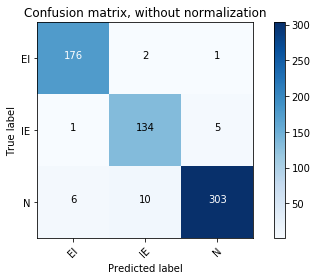

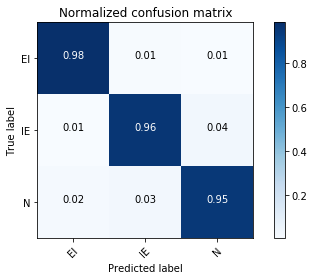

In [33]:
eval_set=[(X_train, y_train), (X_test, y_test)]

xgb = xgboost.sklearn.XGBClassifier(
    objective="multi:softprob",
    learning_rate=0.025,
    seed=9616, #seed that is not random
    max_depth=20,
    gamma=0,
    n_estimators=500)

xgb.fit(X_train, y_train, early_stopping_rounds=20, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=False)
y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("XGBoost classifier Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

MultinomialNB Accuracy:  0.9435736677115988
              precision    recall  f1-score   support

          EI       0.95      0.92      0.94       179
          IE       0.91      0.93      0.92       140
           N       0.95      0.96      0.96       319

   micro avg       0.94      0.94      0.94       638
   macro avg       0.94      0.94      0.94       638
weighted avg       0.94      0.94      0.94       638

Confusion matrix, without normalization
[[165   6   8]
 [  3 130   7]
 [  5   7 307]]
Normalized confusion matrix
[[0.92 0.03 0.04]
 [0.02 0.93 0.05]
 [0.02 0.02 0.96]]


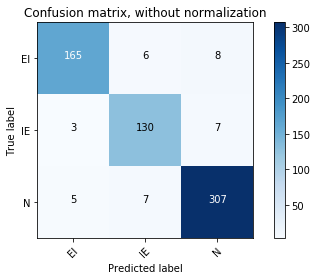

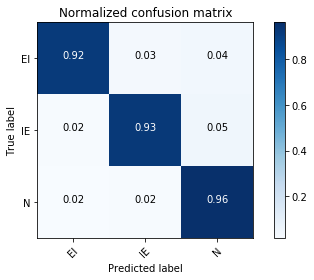

In [34]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("MultinomialNB Accuracy: " , accuracy)

#classification report for each label
print(classification_report(y_test, y_pred))

confusion(y_pred)

(trivial hyperparameters adjusted, 
with same data training set)

### DL algorithm : 

FeedForward Neural network Accuracy:  0.9545454545454546

---

### Classical Machine learning algorithms : 
Values can differ with regard to seed or random states

    1. k_neighbor Accuracy:  0.9278996865203761
    2. Gaussian Naive Bayes Accuracy:  0.9561128526645768
    3. Support Vector Machine Accuracy:  0.9561128526645768
    4. RandomForestClassifier Accuracy:  0.9717868338557993
    5. DecisionTreeClassifier Accuracy:  0.9498432601880877
    6. XGBoost classifier Accuracy:  0.9608150470219435
    7. MultinomialNB Accuracy:  0.9435736677115988


# Remarks
---
Initially, I predicted that it was necessary to implement several hidden layers to classify these dna sequences into three categories. Therefore, I tried to add hidden layers and adjust the number of nodes or learning rates of the DL algorithm. However, it turned out that having only one hidden layer and a few hidden nodes were enough to classify these sequences. (resulting in 95%> accuracy) 

Also, I supposed that for complex data such having 285 columns when onehot encoded, it would be likely that DL perform much better than classical machine learning algorithms. Instead, the result showed that some classical machine learning algorithms even performed better than DL algorithm. This suggest that dna sequence feature was not deeply complicated data, and that classical ML algorithms are much more faster in classifying small data. 

--- 

### Process

**1. Tried to use kmer word count vectorizer because I assumed that dna sequences are turned into protein in chunks of sequences.**
    1. Kmer performed worse than one hot encoding 
    2. Made feature unnecessarily complex
**2. Tried to use heatmap to describe feature importance**
    1. It turned out that for dna sequences it is not possible or feasible to choose certain columns that has more correlation to the label. 
    2. Therefore, I just included all 60 sequences in the data
**3. For some algorithms cross validations were used to assess overfitting of the model**


# Conclusion
___

### ML algorithms performed better in classification task in terms of speed and accuracy, but the difference were trivial.


notebook by Tae Min Ha / taemin410@gmail.com / 01077943915 / 852+67163002 
